## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

y = 'SalePrice'
y_log = 'SalePrice_log'

# One-hot encode categoricals

#### Encode "HeatSystem"

In [3]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys)
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
#print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity'] else x # possibly include Radiant
heating = heating.apply(simplify)
#print('Improved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'}


#### Encode "Condition"

In [4]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)
#print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}


#### Encode "HeatSource"

In [5]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
#print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
#print('Improved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)

#### Encode porch metrics

By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether the presence of a deck impacts SalePrice

Encode as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [6]:
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else 'Open' if x.Open>0 else 'Closed' if x.Encl>0 else 'None'

porches['Porch'] = porches.apply(classify_porches, axis=1)
porches_dummies = pd.get_dummies(porches['Porch'], prefix='Porch', drop_first=False).drop('Porch_None', axis=1)

df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)
porches['Porch'].value_counts();

#### Create one-hot column for whether a home has been renovated

In [7]:
#df_main.loc[df_main.YrRenovated>0, 'YrRenovated'].hist()
encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)

#### Create one-hot column for whether there is a garage and deck

In [8]:
#plt.hist(df_main.SqFtGarageAttached)
encode = lambda x: 1 if x>0 else 0
df_main['Garage'] = df_main.SqFtGarageAttached.apply(encode)
#df_main.Garage.value_counts()

In [9]:
#plt.hist(df_main.SqFtDeck)
encode = lambda x: 1 if x>0 else 0
df_main['Deck'] = df_main.SqFtDeck.apply(encode)
#df_main.Deck.value_counts()

#### Indicate whether or not basement is finished

In [10]:
# basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
# basement.columns = ['fin', 'unfin']
# classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
# basement['Simplified'] = basement.apply(classify_basements, axis=1)
# #print(basement.Simplified.value_counts())
# basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_None', axis=1)
# df_main = pd.concat([df_main, basement_dummies], axis=1)

In [11]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']
classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)
#print(basement.Simplified.value_counts())
basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_Unfinished', axis=1)
df_main = pd.concat([df_main, basement_dummies], axis=1)


# Gain graphical understanding of data
Goal: find the best feature to start the model with. Start with continuous feature

In [12]:
df_main

,SalePrice,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,SqFtDeck,BrickStone,Bedrooms,YrBuilt,YrRenovated,SqFtUnfinBasement,SqFtUnfinished,Bathrooms,Fireplaces,Heating_ElecBB,Heating_FloorWall,Heating_HeatPump,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Fair,Condition_Good,Condition_Poor,Condition_VeryGood,HeatSource_Electricity,HeatSource_Oil,HeatSource_Other,Porch_Both,Porch_Closed,Porch_Open,Renovated,Garage,Deck,Basement_Finished,Basement_None
0,445000,1.0,7,1480,0,0,0,0,440,120,0,3,1994,0,0,0,2.00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,1
1,188500,1.0,5,550,0,0,0,0,0,0,0,2,1942,0,0,0,0.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,730000,2.0,9,1540,380,285,8,0,0,155,0,3,1984,0,95,0,2.25,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1055700,1.0,8,2780,1390,1390,7,0,0,100,0,6,1967,0,0,0,1.75,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,565000,1.0,8,2230,1280,880,7,400,80,100,0,3,2015,0,400,0,2.00,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,391000,1.0,8,1910,620,620,8,0,0,100,0,3,1985,0,0,0,2.25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0
17982,1535000,2.0,9,3220,0,0,0,0,630,0,0,4,2015,0,0,0,3.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
17983,309000,1.5,7,960,0,0,0,0,420,0,0,3,1959,0,0,0,1.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
17984,759990,2.0,8,2010,0,0,0,0,440,0,0,4,1987,0,0,0,2.50,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [13]:
# Identify continous features for pair-plot
continuous_features = []
for col in df_main.columns:
    ct = df_main[col].value_counts().shape[0]
    if (type(df_main[col][0])==type(np.int64(1))) or (type(df_main[col][0])==type(np.float64(0))):
        continuous_features.append(col) if ct>10 else False

# SLOW but potentially powerful pair-plot
#sns.pairplot(df_main[continuous_features], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'g'}, 'scatter_kws': {'alpha': 0.3}});

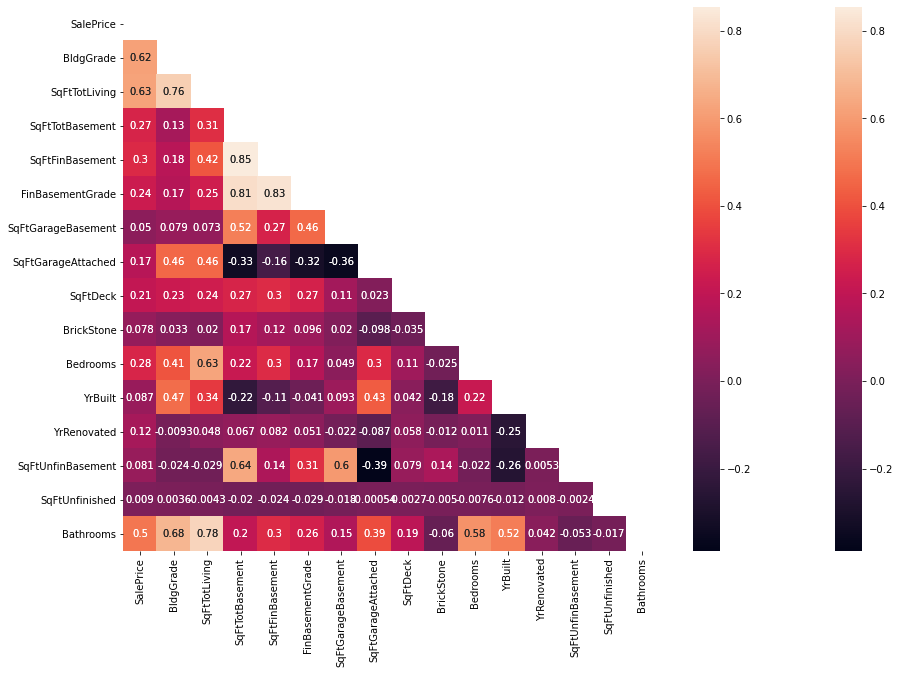

In [14]:
# Heatmap for continuous features
corr = df_main[continuous_features].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);
sns.heatmap(corr, mask=mask, annot=True);

# Create the single-variable model

#### Start with the feature showing the largest correlation with SalePrice

In [15]:
# List correlations of SalePrice and input features
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()
correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True, ignore_index=True)
correlations.head()

,Dependent,Feature,Correlation (abs)
0,SalePrice,SqFtTotLiving,0.625889
1,SalePrice,BldgGrade,0.619405
2,SalePrice,Bathrooms,0.500112
3,SalePrice,Fireplaces,0.325754
4,SalePrice,SqFtFinBasement,0.295106


#### Not surprisingly, the livable square footage is amongst the highest predictors

Let's create the simple model and check the assumptions of Linear Regression. Let's also create a dataframe to store the model performance metrics so we can compare them as we go.

In [16]:
performance_metrics_cols = ['Y', 'X', 'Linearity p-value', 'Jarque-Bera (JB) metric', 'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']
performance_metrics = pd.DataFrame(columns = performance_metrics_cols)

##### Model: **SqFtTotLiving**

Modeling: SalePrice ~ SqFtTotLiving
Linearity p-value (where null hypothesis = linear): 0.00021168866733543726
Normality of Residuals (where null hypothesis = normality): JB stat=13308628.956777703, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.0818282098738738e-98 and f-value's p-value=6.789119645056648e-100
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704


<Figure size 432x288 with 0 Axes>

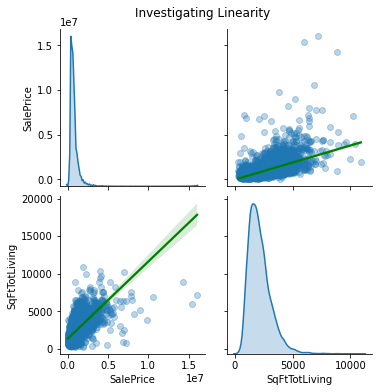

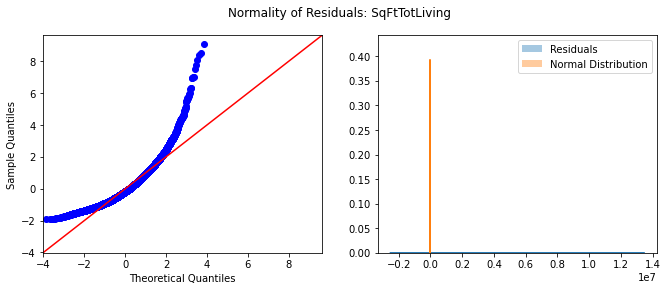

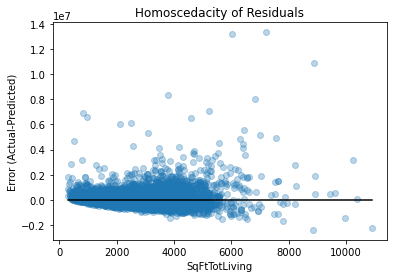

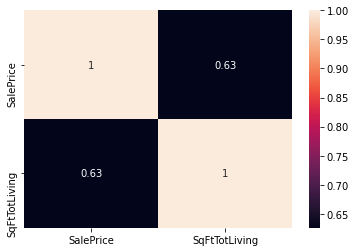

In [17]:
inputs = ['SqFtTotLiving']
output = y

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=inputs[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

##### Clearly, neither SalePrice or SqFtTotLiving are linear. Let's **log-transform** and see the effect

In [18]:
log_transform = lambda x: np.log(x)    
df_main['SalePrice_log'] = df_main.SalePrice.apply(log_transform)
df_main['SqFtTotLiving_log'] = df_main.SqFtTotLiving.apply(log_transform)

##### Model: **SqFtTotLiving_log**

Modeling: SalePrice_log ~ SqFtTotLiving_log
Linearity p-value (where null hypothesis = linear): 0.45982345546689335
Normality of Residuals (where null hypothesis = normality): JB stat=4965.3665420575735, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.1356056075521563e-06 and f-value's p-value=2.1234975744169765e-06
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775


<Figure size 432x288 with 0 Axes>

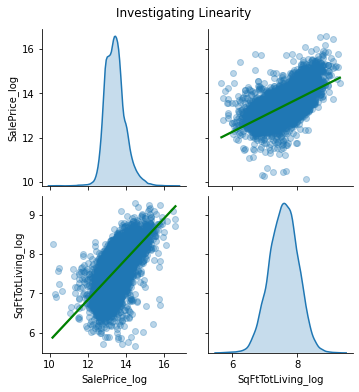

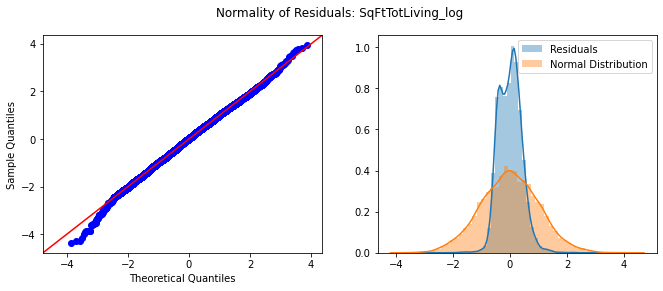

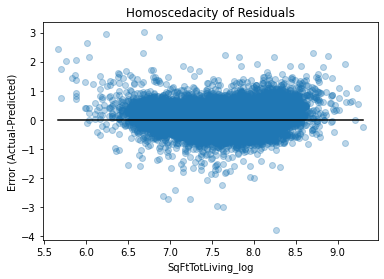

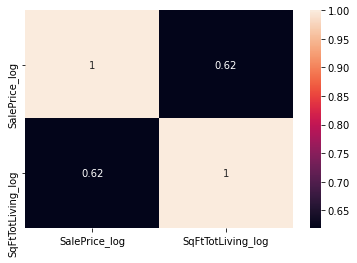

In [19]:
inputs = ['SqFtTotLiving_log']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=inputs[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                 1.120e+04
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:18:55   Log-Likelihood:                -9469.0
No. Observations:               17986   AIC:                         1.894e+04
Df Residuals:                   17984   BIC:                         1.896e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8200      0.053    147.199      0.000       7.716       7.924
SqFtTotLiving_log     0.7408      0.007    105.838      0.000       0.727       0.755
==============================================================================
Omnibus:                     1186.155   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.367
Skew:                           0.190   Prob(JB):                         0.00
Kurtosis:                       5.546   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### This looks much better. Let's see which other features would be best to add using **RFE**

In [21]:
inputs = df_main.drop(['SalePrice_log'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 15)

,BldgGrade,Heating_FloorWall,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Poor,Condition_VeryGood,HeatSource_Oil,HeatSource_Other,Porch_Both,Porch_Closed,Renovated,Garage,Basement_None,SqFtTotLiving_log
0,7,0,0,0,0,0,1,0,0,0,0,0,1,1,7.299797
1,5,1,0,0,0,0,0,1,0,0,0,0,0,1,6.309918
2,9,1,0,0,0,0,0,0,0,0,0,0,0,0,7.339538
3,8,0,0,0,0,0,0,0,0,0,0,0,0,0,7.930206
4,8,0,0,0,0,0,0,0,0,0,0,0,1,0,7.709757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,8,0,0,0,0,0,0,0,0,0,0,0,0,0,7.554859
17982,9,0,0,0,0,0,0,0,0,0,0,0,1,1,8.077137
17983,7,0,0,0,0,0,0,0,0,0,0,0,1,1,6.866933
17984,8,0,0,0,0,0,0,0,0,0,0,0,1,1,7.605890


Porch Open/Closed/Both metrics are the list (one-hot encoded). Let's add those to the model and see the impact. 

Model: **SqFtTotLiving_log, Porch**

In [22]:
inputs = ['SqFtTotLiving_log', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.49321735574714076
Normality of Residuals (where null hypothesis = normality): JB stat=5150.450984113448, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.627382622821402e-05 and f-value's p-value=1.61617270738728e-05
Variance Inflation Factors:
              Feature       VIF
0  SqFtTotLiving_log  2.184274
1         Porch_Open  2.099141
2       Porch_Closed  1.047533
3         Porch_Both  1.037601


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     2835.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:18:56   Log-Likelihood:                -9426.3
No. Observations:               17986   AIC:                         1.886e+04
Df Residuals:                   17981   BIC:                         1.890e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8475      0.055    141.756      0.000       7.739       7.956
SqFtTotLiving_log     0.7346      0.007     99.013      0.000       0.720       0.749
Porch_Open            0.0287      0.007      4.360      0.000       0.016       0.042
Porch_Closed          0.1159      0.021      5.651      0.000       0.076       0.156
Porch_Both            0.1626      0.023      6.984      0.000       0.117       0.208
==============================================================================
Omnibus:                     1206.934   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5150.451
Skew:                           0.190   Prob(JB):                         0.00
Kurtosis:                       5.594   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Overall, a positive addition, though not one that makes a huge difference. Let's see what other attributes could be valauble to add. 

Note that BldgGrade was on the list previously, but we previously saw in the HeatMap that it has a very strong correlation with SqFtTotLiving. Let's not add it to the model so as to avoid colinearity. 

In [24]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 15).head(2)

,Stories,Bedrooms,Bathrooms,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Fair,Condition_Poor,Condition_VeryGood,HeatSource_Oil,HeatSource_Other,Renovated,Garage,Basement_None,SqFtTotLiving_log
0,1.0,3,2.00,0,0,0,0,0,1,0,0,0,1,1,7.299797
1,1.0,2,0.75,0,0,0,0,0,0,1,0,0,0,1,6.309918


We see that the one-hot encoded "Basement_Finished", corresponding to whether or not a basement has been finished, for homes with a basement is on the list. Let's investigate.

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished**

In [25]:
inputs = ['SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.4861165249818504
Normality of Residuals (where null hypothesis = normality): JB stat=5164.132809664697, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=7.838293599906841e-06 and f-value's p-value=7.768799553774086e-06
Variance Inflation Factors:
              Feature       VIF
0  SqFtTotLiving_log  2.372414
1  Basement_Finished  1.162955
2         Porch_Open  2.101589
3       Porch_Closed  1.047593
4         Porch_Both  1.037792


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200


In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     2293.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:18:57   Log-Likelihood:                -9387.4
No. Observations:               17986   AIC:                         1.879e+04
Df Residuals:                   17980   BIC:                         1.883e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.9458      0.056    141.005      0.000       7.835       8.056
SqFtTotLiving_log     0.7199      0.008     94.875      0.000       0.705       0.735
Basement_Finished     0.0815      0.009      8.828      0.000       0.063       0.100
Porch_Open            0.0339      0.007      5.130      0.000       0.021       0.047
Porch_Closed          0.1128      0.020      5.509      0.000       0.073       0.153
Porch_Both            0.1595      0.023      6.865      0.000       0.114       0.205
==============================================================================
Omnibus:                     1205.981   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5164.133
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                       5.598   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Aside from Lagrange multiplier going up slightly, there wasn't much change. However, it does given us some statistically significant findings about finishing a garage, so that's progress. We'll leave interpretation for later.

Use **RFE** to find other valuable additions. Since we already have info about the Basement being finished, let's leave that out.

In [27]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice', 'SqFtFinBasement', 'SqFtUnfinBasement'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 10).head(2)

,Stories,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Poor,HeatSource_Other,Renovated,Garage,Basement_None,SqFtTotLiving_log
0,1.0,0,0,0,0,0,0,1,1,7.299797
1,1.0,0,0,0,0,0,0,0,1,6.309918


I'm curious to know more about the impact of having a garage. Recall that it is one-hot encoded, corresponding to whether one exists or not

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, Garage**

In [28]:
inputs = ['Garage','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ Garage+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.7260329517607229
Normality of Residuals (where null hypothesis = normality): JB stat=6738.414462489172, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=8.643961286504399e-11 and f-value's p-value=8.329423499288428e-11
Variance Inflation Factors:
              Feature       VIF
0             Garage  2.395252
1  SqFtTotLiving_log  3.508805
2  Basement_Finished  1.173472
3         Porch_Open  2.147930
4       Porch_Closed  1.052494
5         Porch_Both  1.045025


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809


In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     2135.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:18:58   Log-Likelihood:                -8986.4
No. Observations:               17986   AIC:                         1.799e+04
Df Residuals:                   17979   BIC:                         1.804e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.5465      0.057    132.754      0.000       7.435       7.658
Garage               -0.1843      0.006    -28.635      0.000      -0.197      -0.172
SqFtTotLiving_log     0.7858      0.008    101.140      0.000       0.771       0.801
Basement_Finished     0.0437      0.009      4.792      0.000       0.026       0.062
Porch_Open            0.0477      0.006      7.376      0.000       0.035       0.060
Porch_Closed          0.0796      0.020      3.972      0.000       0.040       0.119
Porch_Both            0.1049      0.023      4.604      0.000       0.060       0.150
==============================================================================
Omnibus:                     1324.862   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6738.414
Skew:                           0.142   Prob(JB):                         0.00
Kurtosis:                       5.985   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That is telling us that the presence of a garage is correlated with a significantly lower SalePrice. Huh. That's surprising. Let's look at Garage on a square-footage basis instead.
##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, SqFtGarage**

In [30]:
inputs = ['SqFtGarageAttached','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtGarageAttached+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.5193331686385174
Normality of Residuals (where null hypothesis = normality): JB stat=5992.585885762078, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.6416457422678657e-06 and f-value's p-value=2.6108176048188182e-06
Variance Inflation Factors:
               Feature       VIF
0  SqFtGarageAttached  2.089954
1   SqFtTotLiving_log  3.041610
2   Basement_Finished  1.168181
3          Porch_Open  2.209289
4        Porch_Closed  1.050431
5          Porch_Both  1.040675


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     2003.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:18:58   Log-Likelihood:                -9219.5
No. Observations:               17986   AIC:                         1.845e+04
Df Residuals:                   17979   BIC:                         1.851e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.5244      0.060    124.701      0.000       7.406       7.643
SqFtGarageAttached    -0.0002   1.19e-05    -18.409      0.000      -0.000      -0.000
SqFtTotLiving_log      0.7829      0.008     94.781      0.000       0.767       0.799
Basement_Finished      0.0559      0.009      6.043      0.000       0.038       0.074
Porch_Open             0.0481      0.007      7.305      0.000       0.035       0.061
Porch_Closed           0.0995      0.020      4.902      0.000       0.060       0.139
Porch_Both             0.1369      0.023      5.941      0.000       0.092       0.182
==============================================================================
Omnibus:                     1276.276   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5992.586
Skew:                           0.169   Prob(JB):                         0.00
Kurtosis:                       5.807   Cond. No.                     8.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The findings are inconsequential. Looking at the distribution of the SqFtGarageAttached data, it looks like a log transformation could provide powerful insight. However, keep in mind that there are many homes without garages, leaving us with *log(0)*, which gives us an error. We'll instead add a small number to the whole feature such that all values are positive. This inherently introduces error, but with a small additive value, the additional error is very small. 
##### **Log transform** SqFtGarageAttached

In [32]:
add_then_log_transform = lambda x: np.log(x+1)    
df_main['SqFtGarageAttached_log'] = df_main.SalePrice.apply(add_then_log_transform)

##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, SqFtGarage_log**

In [33]:
inputs = ['SqFtGarageAttached_log','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtGarageAttached_log+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.9999999999999999
Normality of Residuals (where null hypothesis = normality): JB stat=970030463.0155722, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.1914598001455177e-80 and f-value's p-value=2.8735211981531538e-81
Variance Inflation Factors:
                   Feature         VIF
0  SqFtGarageAttached_log  516.111614
1       SqFtTotLiving_log  527.317187
2       Basement_Finished    1.174511
3              Porch_Open    2.174996
4            Porch_Closed    1.051987
5              Porch_Both    1.039614


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000


Nope. That gives hugely colinear data bwith SqFtTotLiving_log. Since we want to compare the value of a garage and a bedroom, let's ignore garage square footage, keep the one-hot garage metric, and add in the **Bedrooms**
##### Model: **SqFtTotLiving_log, Porch, Basement_Finished, Bedrooms**

In [34]:
inputs = ['Bedrooms','SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ Bedrooms+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.6064404718589589
Normality of Residuals (where null hypothesis = normality): JB stat=5191.512613301513, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=3.2904867275237385e-11 and f-value's p-value=3.161149048982936e-11
Variance Inflation Factors:
              Feature        VIF
0           Bedrooms  20.779324
1  SqFtTotLiving_log  20.863268
2  Basement_Finished   1.174628
3         Porch_Open   2.127833
4       Porch_Closed   1.050188
5         Porch_Both   1.038486


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788


The colinearity with SqFtTotLiving and Bedrooms is too high. Let's get rid of SqFtTotLiving_Log and try again.
##### Model: **Porch, Basement_Finished, Bedrooms, Garage**

Modeling: SalePrice_log ~ Bedrooms_cut+Garage+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.024392059580623637
Normality of Residuals (where null hypothesis = normality): JB stat=3305.0856129010745, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=4.7093001170211694e-24 and f-value's p-value=3.897631040760771e-24
Variance Inflation Factors:
              Feature       VIF
0       Bedrooms_cut  3.612166
1             Garage  2.487745
2  Basement_Finished  1.179502
3         Porch_Open  2.122467
4       Porch_Closed  1.040773
5         Porch_Both  1.037032


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     542.7
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:19:01   Log-Likelihood:                -11971.
No. Observations:               17732   AIC:                         2.396e+04
Df Residuals:                   17725   BIC:                         2.401e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.7350      0.015    853.458      0.000      12.706      12.764
Bedrooms_cut          0.1790      0.005     39.689      0.000       0.170       0.188
Garage               -0.0697      0.008     -9.126      0.000      -0.085      -0.055
Basement_Finished     0.2054      0.011     18.954      0.000       0.184       0.227
Porch_Open            0.1921      0.008     25.615      0.000       0.177       0.207
Porch_Closed          0.0766      0.024      3.197      0.001       0.030       0.124
Porch_Both            0.1685      0.027      6.156      0.000       0.115       0.222
==============================================================================
Omnibus:                     1232.010   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3305.086
Skew:                           0.394   Prob(JB):                         0.00
Kurtosis:                       4.963   Cond. No.                         28.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 432x288 with 0 Axes>

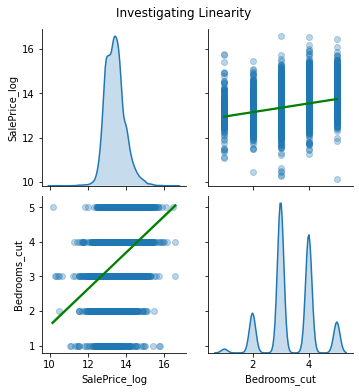

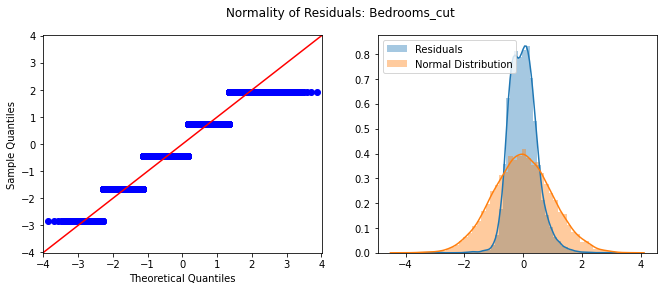

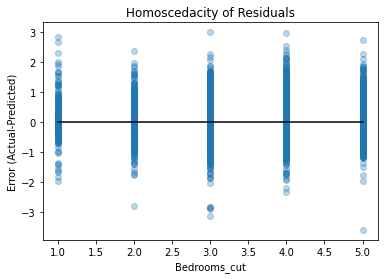

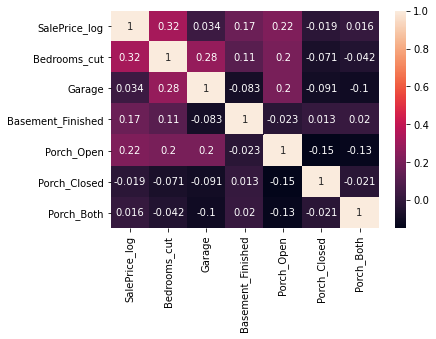

In [35]:
inputs = ['Bedrooms_cut','Garage', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

df_main_cut = df_main.copy()
df_main_cut['Bedrooms_cut'] = cut_extremes(df_main_cut.Bedrooms, 3)

model, df_model = produce_model(df_main_cut.dropna(), inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='Bedrooms_cut')
performance_metrics = performance_metrics.append(results)
performance_metrics
model.summary()

Modeling: SalePrice_log ~ Bedrooms+Garage+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.10008311269107187
Normality of Residuals (where null hypothesis = normality): JB stat=3232.468185132693, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=9.364774730136273e-30 and f-value's p-value=7.047578426052284e-30
Variance Inflation Factors:
              Feature       VIF
0           Bedrooms  3.585967
1             Garage  2.457815
2  Basement_Finished  1.189727
3         Porch_Open  2.132398
4       Porch_Closed  1.039195
5         Porch_Both  1.036738


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.024392,3.305086e+03,0.0,122.565980,4.709300e-24,20.561725,3.897631e-24,1.91328,0.154901
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.100083,3.232468e+03,0.0,149.607849,9.364775e-30,25.134002,7.047578e-30,1.90697,0.161990


<Figure size 432x288 with 0 Axes>

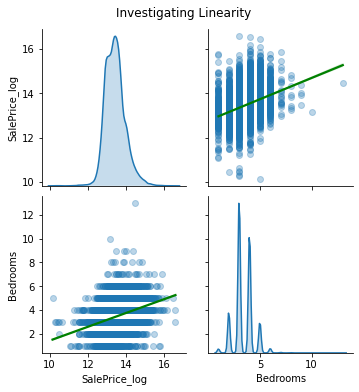

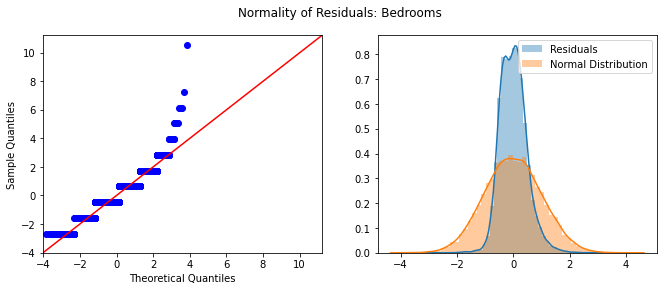

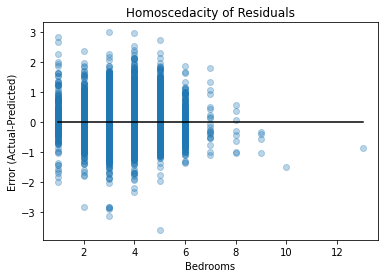

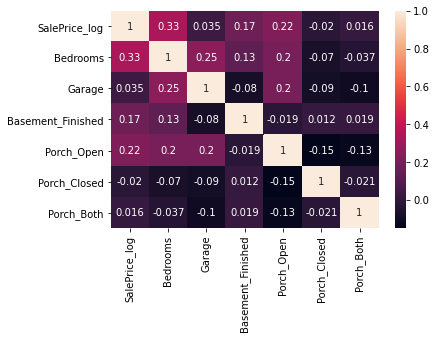

In [36]:
inputs = ['Bedrooms','Garage', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='Bedrooms')
performance_metrics = performance_metrics.append(results)
performance_metrics

This makes every metric worse. 

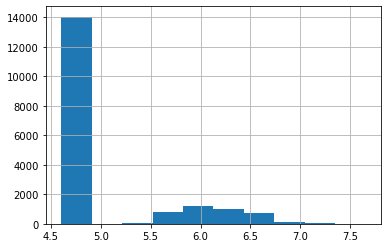

In [37]:
logx = lambda x: np.log(x+100)
(df_main.SqFtGarageBasement.apply(logx)).hist()

Modeling: SalePrice_log ~ Bedrooms_cut+SqFtGarageBasement+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.42781614395701


C:\Users\seths\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Normality of Residuals (where null hypothesis = normality): JB stat=5326.166923782391, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.1289352323024745e-12 and f-value's p-value=1.0681359915507447e-12
Variance Inflation Factors:
               Feature        VIF
0        Bedrooms_cut  23.536559
1  SqFtGarageBasement   1.296281
2   SqFtTotLiving_log  23.854825
3   Basement_Finished   1.211392
4          Porch_Open   2.158786
5        Porch_Closed   1.051092
6          Porch_Both   1.040192


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.024392,3.305086e+03,0.0,122.565980,4.709300e-24,20.561725,3.897631e-24,1.91328,0.154901
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.100083,3.232468e+03,0.0,149.607849,9.364775e-30,25.134002,7.047578e-30,1.90697,0.161990


<Figure size 432x288 with 0 Axes>

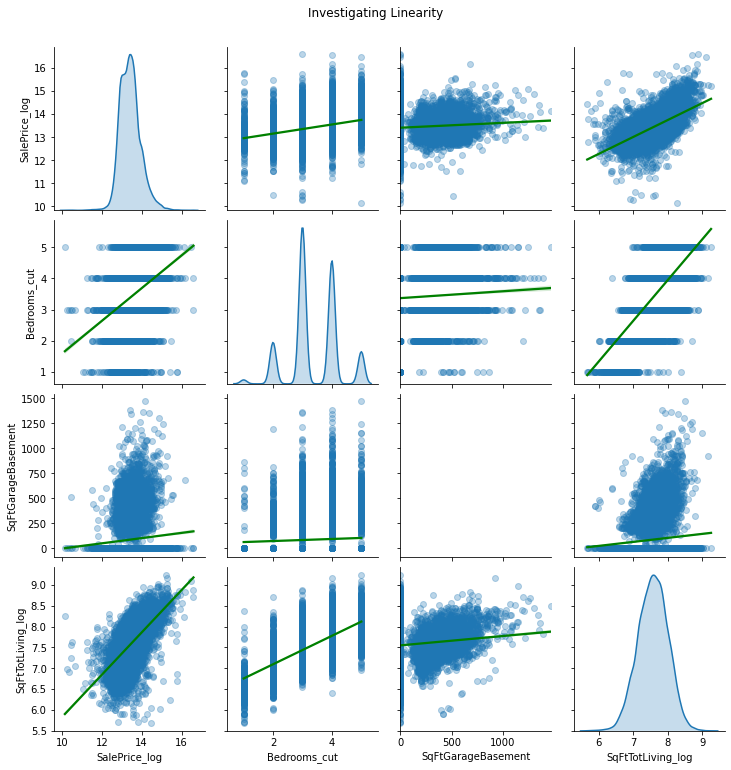

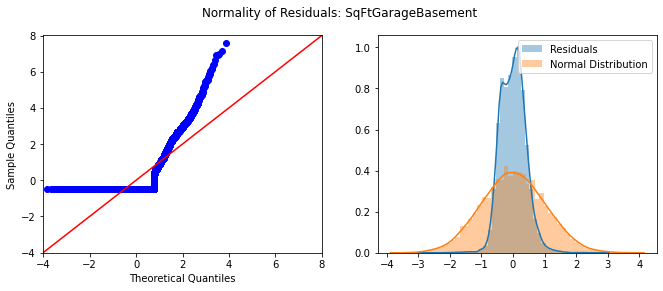

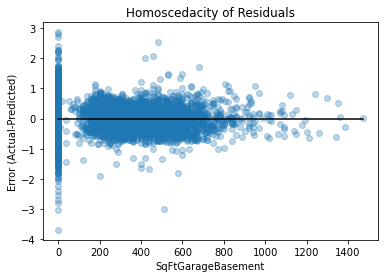

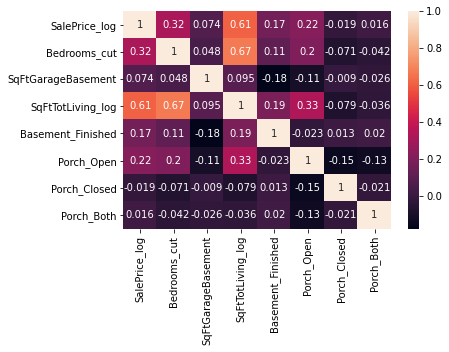

In [38]:
#plt.hist(df_main.SqFtGarageAttached)
encode = lambda x: 1 if x>0 else 0
df_main['GarageBasement'] = df_main.SqFtGarageBasement.apply(encode)
#df_main.Garage.value_counts()


inputs = ['Bedrooms_cut','SqFtGarageBasement', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log

model, df_model = produce_model(df_main_cut.dropna(), inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='SqFtGarageBasement')
performance_metrics = performance_metrics.append(results)
performance_metrics
#model.summary()

#sns.pairplot(df_main[inputs]);

#### It looks like it's time to move past Garage data. I don't see statistical significance in a model that passes the linear regression assumption tests

Let's isolate some more interesting features

In [39]:
inputs = df_main.drop(['SalePrice_log', 'BldgGrade', 'SalePrice', 'SqFtFinBasement', 'SqFtUnfinBasement'], axis=1)
output = df_main.SalePrice_log
recursive_feature_elimination(inputs, output, 10).head(2)

,Heating_ElecBB,Heating_FloorWall,Heating_HotWater,Heating_Other,Condition_Fair,Condition_Poor,HeatSource_Other,Renovated,SqFtTotLiving_log,SqFtGarageAttached_log
0,0,0,0,0,0,0,0,0,7.299797,13.005832
1,0,1,0,0,0,0,0,0,6.309918,12.146859


One-hot encoded versions of the heating method seem to be very relevant and strong contributors to a high R^2 model. Let's try adding them to the most functional model we have had so far. 
##### Model: **Heating** plus others. Recall that "Forced Air" is the default (dropped) column here

In [40]:
df_main.columns.sort_values()

Index(['Basement_Finished', 'Basement_None', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'BrickStone', 'Condition_Fair', 'Condition_Good',
       'Condition_Poor', 'Condition_VeryGood', 'Deck', 'FinBasementGrade',
       'Fireplaces', 'Garage', 'GarageBasement', 'HeatSource_Electricity',
       'HeatSource_Oil', 'HeatSource_Other', 'Heating_ElecBB',
       'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater',
       'Heating_Other', 'Heating_Radiant', 'Porch_Both', 'Porch_Closed',
       'Porch_Open', 'Renovated', 'SalePrice', 'SalePrice_log', 'SqFtDeck',
       'SqFtFinBasement', 'SqFtGarageAttached', 'SqFtGarageAttached_log',
       'SqFtGarageBasement', 'SqFtTotBasement', 'SqFtTotLiving',
       'SqFtTotLiving_log', 'SqFtUnfinBasement', 'SqFtUnfinished', 'Stories',
       'YrBuilt', 'YrRenovated'],
      dtype='object')

Modeling: SalePrice_log ~ Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.5121949638997888
Normality of Residuals (where null hypothesis = normality): JB stat=5351.202718936968, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.00013810870935227515 and f-value's p-value=0.0001370261555400081
Variance Inflation Factors:
              Feature       VIF
0     Heating_ElecBB  1.076236
1  Heating_FloorWall  1.041579
2   Heating_HeatPump  1.118869
3   Heating_HotWater  1.035090
4    Heating_Radiant  1.018638
5  SqFtTotLiving_log  2.683745
6  Basement_Finished  1.172356
7         Porch_Open  2.126105
8       Porch_Closed  1.049010
9         Porch_Both  1.042467
                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:    

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.024392,3.305086e+03,0.0,122.565980,4.709300e-24,20.561725,3.897631e-24,1.91328,0.154901
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.100083,3.232468e+03,0.0,149.607849,9.364775e-30,25.134002,7.047578e-30,1.90697,0.161990


<Figure size 432x288 with 0 Axes>

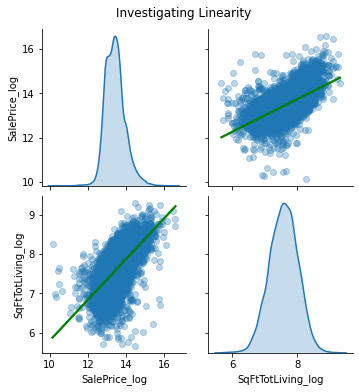

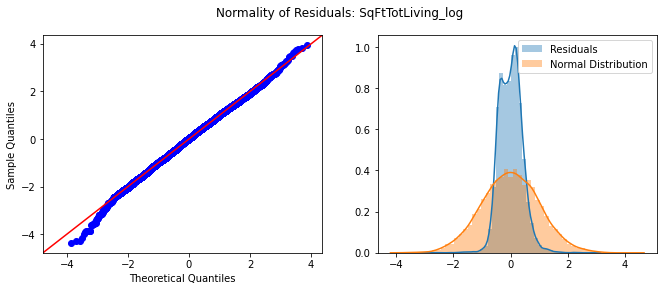

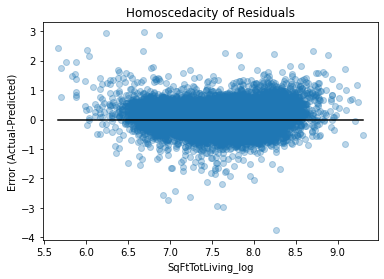

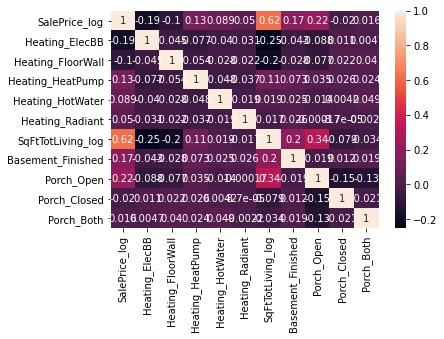

In [41]:
inputs = ['Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log




model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot='SqFtTotLiving_log')
performance_metrics = performance_metrics.append(results)

print(model.summary())
performance_metrics


In [42]:
# ADDED 'RENOVATED' - CONCLUSION: ADDING RENOVATED MAKES IT WORSE. REMOVE.
inputs = ['Renovated','Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log


model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)

print(model.summary())
performance_metrics

Modeling: SalePrice_log ~ Renovated+Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both
Linearity p-value (where null hypothesis = linear): 0.441459011019065
Normality of Residuals (where null hypothesis = normality): JB stat=5253.862196096502, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=1.4322846250240587e-08 and f-value's p-value=1.3887983607662518e-08
Variance Inflation Factors:
               Feature       VIF
0           Renovated  1.060902
1      Heating_ElecBB  1.077283
2   Heating_FloorWall  1.041625
3    Heating_HeatPump  1.118892
4    Heating_HotWater  1.035415
5     Heating_Radiant  1.018885
6   SqFtTotLiving_log  2.710634
7   Basement_Finished  1.179572
8          Porch_Open  2.126511
9        Porch_Closed  1.049106
10         Porch_Both  1.043043
                            OLS Regression Results                            
D

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.024392,3.305086e+03,0.0,122.565980,4.709300e-24,20.561725,3.897631e-24,1.91328,0.154901
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.100083,3.232468e+03,0.0,149.607849,9.364775e-30,25.134002,7.047578e-30,1.90697,0.161990


## Implement new forward-selection feature with current features having a satisfactory p-value

In [43]:
# Verify through stepwise selection as a backup check that each of these inputs do in fact have a satisfactory p-value in the model
if 'Renovated' in inputs:
    inputs.remove('Renovated')
keepers = stepwise_selection(df_main[inputs], df_main[y_log], verbose=True)

Add  SqFtTotLiving_log              with p-value 0.0
Add  Heating_HotWater               with p-value 1.98797e-40
Add  Heating_HeatPump               with p-value 6.17313e-27
Add  Heating_Radiant                with p-value 1.22342e-28
Add  Basement_Finished              with p-value 3.72955e-14
Add  Porch_Both                     with p-value 1.42866e-07
Add  Heating_ElecBB                 with p-value 6.40446e-07
Add  Porch_Open                     with p-value 7.00513e-06
Add  Porch_Closed                   with p-value 3.304e-07
Add  Heating_FloorWall              with p-value 1.37603e-05
Remaining features: ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_HeatPump', 'Heating_Radiant', 'Basement_Finished', 'Porch_Both', 'Heating_ElecBB', 'Porch_Open', 'Porch_Closed', 'Heating_FloorWall']
Removed features: []


##### Tests passed.

## Run forward-selection to see other valuable features

In [44]:
df_main

,SalePrice,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,SqFtDeck,BrickStone,Bedrooms,YrBuilt,YrRenovated,SqFtUnfinBasement,SqFtUnfinished,Bathrooms,Fireplaces,Heating_ElecBB,Heating_FloorWall,Heating_HeatPump,Heating_HotWater,Heating_Other,Heating_Radiant,Condition_Fair,Condition_Good,Condition_Poor,Condition_VeryGood,HeatSource_Electricity,HeatSource_Oil,HeatSource_Other,Porch_Both,Porch_Closed,Porch_Open,Renovated,Garage,Deck,Basement_Finished,Basement_None,SalePrice_log,SqFtTotLiving_log,SqFtGarageAttached_log,GarageBasement
0,445000,1.0,7,1480,0,0,0,0,440,120,0,3,1994,0,0,0,2.00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,1,13.005830,7.299797,13.005832,0
1,188500,1.0,5,550,0,0,0,0,0,0,0,2,1942,0,0,0,0.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,12.146853,6.309918,12.146859,0
2,730000,2.0,9,1540,380,285,8,0,0,155,0,3,1984,0,95,0,2.25,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,13.500800,7.339538,13.500801,0
3,1055700,1.0,8,2780,1390,1390,7,0,0,100,0,6,1967,0,0,0,1.75,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,13.869715,7.930206,13.869716,0
4,565000,1.0,8,2230,1280,880,7,400,80,100,0,3,2015,0,400,0,2.00,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,13.244581,7.709757,13.244583,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,391000,1.0,8,1910,620,620,8,0,0,100,0,3,1985,0,0,0,2.25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,12.876463,7.554859,12.876465,0
17982,1535000,2.0,9,3220,0,0,0,0,630,0,0,4,2015,0,0,0,3.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,14.244041,8.077137,14.244042,0
17983,309000,1.5,7,960,0,0,0,0,420,0,0,3,1959,0,0,0,1.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,12.641097,6.866933,12.641100,0
17984,759990,2.0,8,2010,0,0,0,0,440,0,0,4,1987,0,0,0,2.50,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,13.541061,7.605890,13.541062,0


In [45]:
remaining_columns = df_main.drop(['SalePrice', 'SqFtTotLiving', 'BldgGrade', 'Renovated', 'FinBasementGrade', 'SqFtGarageAttached_log', 'HeatSource_Other'], axis=1)

#model_this = pd.concat([df_main.SqFtTotLiving_log, df_main.SalePrice_log, df_main.iloc[:, 1:10]], axis=1)
# model_new = forward_selected(remaining_columns, 'SalePrice_log')
# print(model_new.summary())

# Step-wise feature selection: remove features with low p-value

In [46]:
df_main.columns

Index(['SalePrice', 'Stories', 'BldgGrade', 'SqFtTotLiving', 'SqFtTotBasement',
       'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement',
       'SqFtGarageAttached', 'SqFtDeck', 'BrickStone', 'Bedrooms', 'YrBuilt',
       'YrRenovated', 'SqFtUnfinBasement', 'SqFtUnfinished', 'Bathrooms',
       'Fireplaces', 'Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump',
       'Heating_HotWater', 'Heating_Other', 'Heating_Radiant',
       'Condition_Fair', 'Condition_Good', 'Condition_Poor',
       'Condition_VeryGood', 'HeatSource_Electricity', 'HeatSource_Oil',
       'HeatSource_Other', 'Porch_Both', 'Porch_Closed', 'Porch_Open',
       'Renovated', 'Garage', 'Deck', 'Basement_Finished', 'Basement_None',
       'SalePrice_log', 'SqFtTotLiving_log', 'SqFtGarageAttached_log',
       'GarageBasement'],
      dtype='object')

In [53]:
# Verify through stepwise selection as a backup check that each of these inputs do in fact have a satisfactory p-value in the model

df_inputs = df_main.drop(['HeatSource_Other', 'HeatSource_Electricity', 'HeatSource_Oil', 'Basement_None', 'SalePrice', 'BldgGrade', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached', 'Bedrooms', 'SqFtGarageAttached_log', 'Renovated', 'SqFtUnfinBasement'], axis=1)
keepers = stepwise_selection(df_inputs, df_main[y_log], verbose=True)

Add  Stories                        with p-value 0.0
Add  Bathrooms                      with p-value 0.0
Add  SqFtTotLiving_log              with p-value 0.0
Add  SalePrice_log                  with p-value 0.0
Add  SqFtDeck                       with p-value 0.0
Drop Bathrooms                      with p-value 0.996689
Add  BrickStone                     with p-value 0.0
Add  YrRenovated                    with p-value 0.0
Drop SqFtTotLiving_log              with p-value 0.778715
Add  YrBuilt                        with p-value 9.2524e-82
Drop BrickStone                     with p-value 0.773995
Drop SqFtDeck                       with p-value 0.787023
Add  SqFtDeck                       with p-value 1.13517e-17
Add  SqFtUnfinished                 with p-value 5.87023e-30
Remaining features: ['Stories', 'SalePrice_log', 'YrRenovated', 'YrBuilt', 'SqFtDeck', 'SqFtUnfinished']
Removed features: []


In [56]:
model_new = forward_selected(df_inputs, 'SalePrice_log')
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     654.7
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:23:37   Log-Likelihood:                -7997.7
No. Observations:               17986   AIC:                         1.605e+04
Df Residuals:                   17960   BIC:                         1.625e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             15.6727      0

Overal, we find that we have looked into most of the fields that are added to this model, whether by adding to a model or looking at plots. 
## Final Decision

In [74]:
# ADDED 'RENOVATED' - CONCLUSION: ADDING RENOVATED MAKES IT WORSE. REMOVE.
inputs = ['Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant', 'SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 'Porch_Closed', 'Porch_Both']
output = y_log


model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)

#print(model.summary())
performance_metrics

Modeling: SalePrice_log ~ Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant+SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000212,1.330863e+07,0.0,444.596151,1.081828e-98,455.813984,6.789120e-100,NA,0.391704
0,SalePrice_log,SqFtTotLiving_log,0.459823,4.965367e+03,0.0,22.469017,2.135606e-06,22.494620,2.123498e-06,NA,0.383775
0,SalePrice_log,SqFtTotLiving_log+Porch_Open+Porch_Closed+Porc...,0.493217,5.150451e+03,0.0,27.429613,1.627383e-05,6.865968,1.616173e-05,1.59214,0.386587
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.486117,5.164133e+03,0.0,31.391737,7.838294e-06,6.287226,7.768800e-06,1.54447,0.389200
0,SalePrice_log,Garage+SqFtTotLiving_log+Basement_Finished+Por...,0.726033,6.738414e+03,0.0,58.603880,8.643961e-11,9.795428,8.329423e-11,1.88716,0.415809
0,SalePrice_log,SqFtGarageAttached+SqFtTotLiving_log+Basement_...,0.519333,5.992586e+03,0.0,36.095191,2.641646e-06,6.025616,2.610818e-06,1.76669,0.400466
0,SalePrice_log,SqFtGarageAttached_log+SqFtTotLiving_log+Basem...,1.000000,9.700305e+08,0.0,386.535184,2.191460e-80,65.811813,2.873521e-81,174.812,1.000000
0,SalePrice_log,Bedrooms+SqFtTotLiving_log+Basement_Finished+P...,0.606440,5.191513e+03,0.0,60.669450,3.290487e-11,10.141850,3.161149e-11,7.83895,0.400788
0,SalePrice_log,Bedrooms_cut+Garage+Basement_Finished+Porch_Op...,0.024392,3.305086e+03,0.0,122.565980,4.709300e-24,20.561725,3.897631e-24,1.91328,0.154901
0,SalePrice_log,Bedrooms+Garage+Basement_Finished+Porch_Open+P...,0.100083,3.232468e+03,0.0,149.607849,9.364775e-30,25.134002,7.047578e-30,1.90697,0.161990


By running this model through the Forward Selection algorithm, we see that all metrics are retained, indicating that each one has a positive impact on R^2.

In [75]:
model_new = forward_selected(df_main[[y_log]+inputs], 'SalePrice_log')
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     1217.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:39:33   Log-Likelihood:                -9173.4
No. Observations:               17986   AIC:                         1.837e+04
Df Residuals:                   17975   BIC:                         1.845e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.9993      0.05

### **Export Results** to analyze the significance of the final model's results

In [83]:
# *** WRITE TO SQL DB ***

conn = sqlite3.connect('../../data/processed/main.db')
df_model.to_sql('step3_final_df', conn, if_exists='replace')
performance_metrics.to_sql('step3_performance_metrics', conn, if_exists='replace')

conn.close()
# ******

C:\Users\seths\anaconda3\lib\site-packages\pandas\core\generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(
